In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [241]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [242]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2344.000000,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2.344000e+03
mean,7548.350621,-0.990424,-5.895742e-07,-0.000168,-4.952150e-07,-0.000011,2.453067e-07,1.729460e-08
std,4349.693426,0.001021,3.212275e-03,0.000715,2.139333e-03,0.006607,1.474166e-03,2.512213e-08
min,19.280590,-0.991668,-4.523862e-03,-0.001139,-3.247579e-03,-0.009040,-2.084719e-03,-2.785758e-08
25%,3783.815250,-0.991459,-3.224401e-03,-0.000878,-1.993437e-03,-0.006529,-1.487002e-03,-2.321468e-09
50%,7548.350500,-0.990587,-1.529082e-05,-0.000219,-5.756147e-06,-0.000394,6.194265e-06,1.033334e-08
75%,11312.887500,-0.989400,3.228971e-03,0.000540,1.972725e-03,0.006461,1.480479e-03,3.709943e-08
max,15077.420000,-0.988843,4.523994e-03,0.000913,3.247771e-03,0.009939,2.084456e-03,7.822104e-08


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

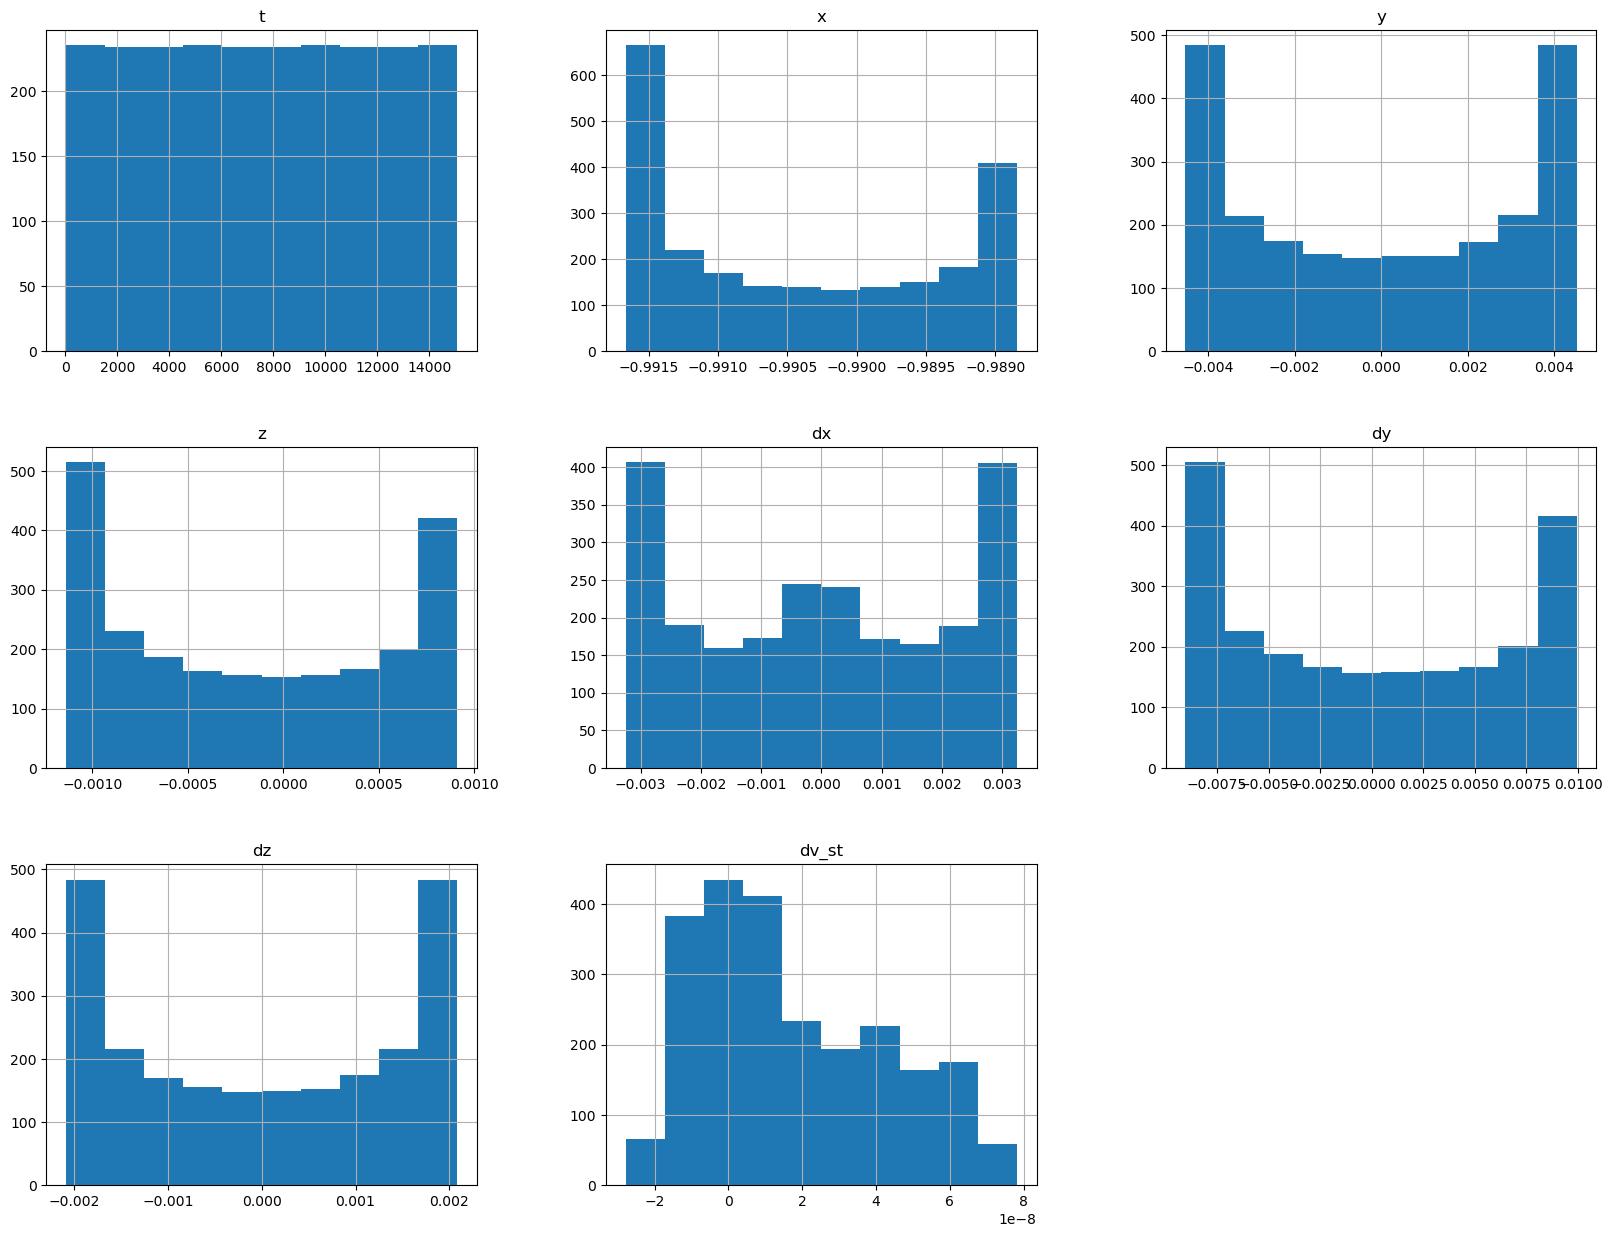

In [243]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Visualizing Data

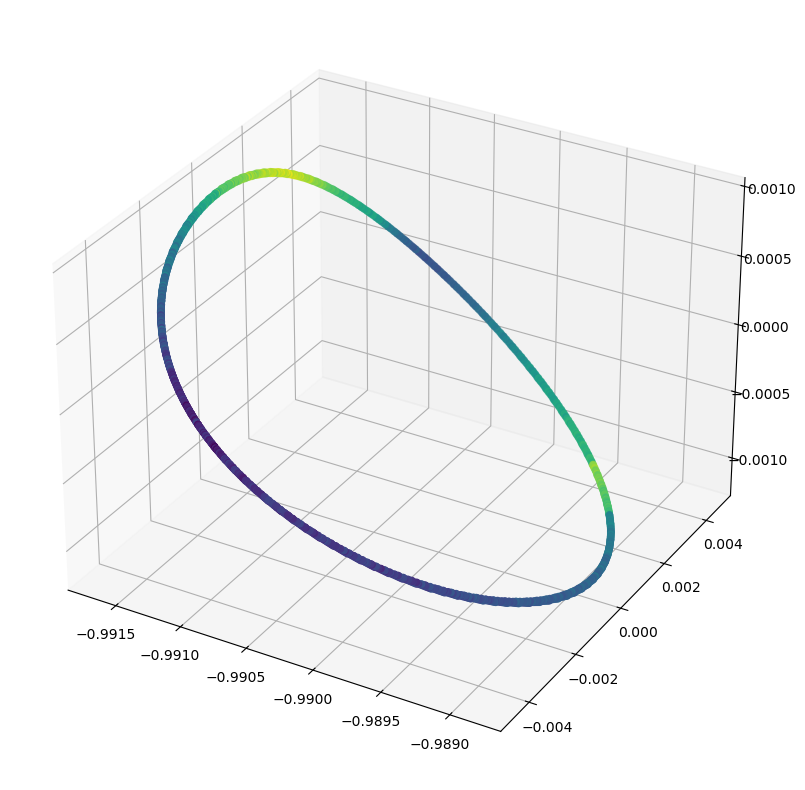

In [244]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [245]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.649538
dx       0.606080
z        0.344936
dy       0.342805
x       -0.263549
dz      -0.655981
Name: dv_st, dtype: float64

array([[<Axes: xlabel='x', ylabel='x'>, <Axes: xlabel='dx', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='x', ylabel='dx'>,
        <Axes: xlabel='dx', ylabel='dx'>,
        <Axes: xlabel='dv_st', ylabel='dx'>],
       [<Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dx', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

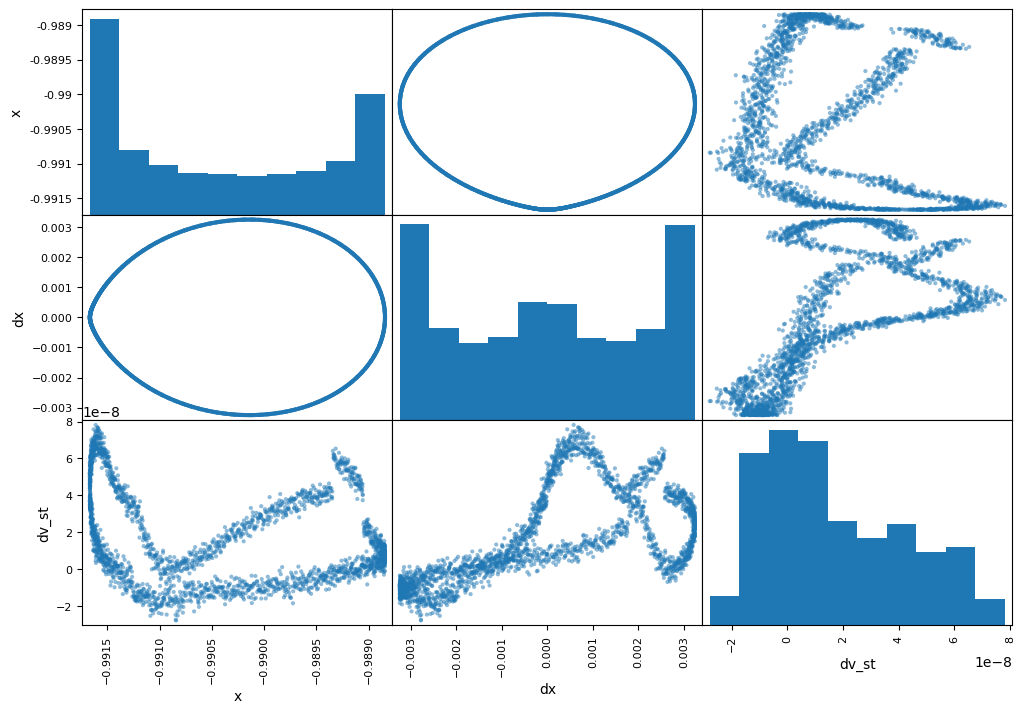

In [246]:
#attributes = ["angle", "x", "dx", "dv_st"]
attributes = ["x", "dx", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

## Create a Train/Test Set

In [247]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.989189,0.002520,-0.000968,0.002222,-0.007492,-0.001014
1,-0.988843,-0.000112,-0.001121,-0.000103,-0.009031,0.000045
2,-0.989246,-0.002703,-0.000941,-0.002366,-0.007233,0.001091
3,-0.990157,-0.004300,-0.000479,-0.003245,-0.002797,0.001838
4,-0.991066,-0.004307,0.000136,-0.002407,0.002813,0.002033


In [248]:
## Create Train/Test/Validation Sets

In [249]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(1406, 6)
(469, 6)
(469, 6)


,x,y,z,dx,dy,dz
1156,-0.991640,-0.001510,0.000839,-0.000366,0.009283,0.000837
1666,-0.989440,0.003218,-0.000861,0.002745,-0.006344,-0.001327
1135,-0.991239,-0.004035,0.000294,-0.002015,0.004222,0.001977
997,-0.991590,-0.002343,0.000738,-0.000696,0.008321,0.001265
863,-0.989155,0.002404,-0.000989,0.002129,-0.007646,-0.000971


In [250]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.00980739, 0.33310444, 0.96463929, 0.44356925, 0.96547936,
        0.70107209],
       [0.78862767, 0.85566625, 0.13546295, 0.92252088, 0.14204482,
        0.18147423],
       [0.15153661, 0.05399699, 0.69855536, 0.18970356, 0.69876012,
        0.9746389 ],
       [0.02733324, 0.24102472, 0.91552889, 0.39289416, 0.91479255,
        0.80383224],
       [0.88932163, 0.76567167, 0.07295445, 0.82769166, 0.07344267,
        0.26687362]])

In [251]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [252]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [253]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(X_train_scaled)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.10329877701871053

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [254]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = tree_reg.predict(X_train_scaled)
tree_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

NOW THIS IS MUCH BETTER!!

In [255]:
#Let's try it out on 5 instances from the test set
some_data = X_test_scaled[10:20]
some_labels = y_test_scaled[10:20]
print("Predictions:", list(tree_reg.predict(some_data)))
print("Labels:", list(some_labels))

Predictions: [0.2787773780585131, 0.7070951425665908, 0.6337341434064497, 0.5755061549738527, 0.5871702041773892, 0.86500501883171, 0.7228312145095709, 0.5477366218630633, 0.12125833240073988, 0.8821394562603165]
Labels: [array([0.3170073]), array([0.61765509]), array([0.67350384]), array([0.54658192]), array([0.60002044]), array([0.87225769]), array([0.73112991]), array([0.53686463]), array([0.15918774]), array([0.92491463])]


In [256]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train_scaled)

maneuvers_predictions = forest_reg.predict(X_train_scaled)
forest_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.014917230003214429

## Polynomial Regression

In [257]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(X_train_scaled)
#print(X_train_scaled.head())
#print(maneuvers_pred_poly[0])

In [258]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, y_train_scaled)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.04853934378631043

## SVM Regression

In [259]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(X_train_scaled, y_train_scaled)
maneuvers_predictions = svm_poly_reg.predict(X_train_scaled)
svm_mse = mean_squared_error(y_train_scaled, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.07410440595197497

## Cross-validation

Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [260]:
from sklearn.model_selection import cross_val_score
tree_reg = DecisionTreeRegressor()
scores = cross_val_score(tree_reg, X_train_scaled, y_train_scaled,
scoring="neg_root_mean_squared_error", cv=5)
tree_rmse_scores = -scores

In [261]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [0.05180926 0.0532473  0.05060166 0.04805546 0.05235363]
Mean: 0.05121346086244758
Standard deviation: 0.0017965916113943763
